In [47]:
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from PIL import Image
import os

In [17]:
def compute_homography(points1, points2):
    A = []
    for (x1, y1), (x2, y2) in zip(points1, points2):
        A.append([-x1, -y1, -1, 0, 0, 0, x1 * x2, y1 * x2, x2])
        A.append([0, 0, 0, -x1, -y1, -1, x1 * y2, y1 * y2, y2])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    H /= H[2, 2]
    return H

In [18]:
def transform_image(image, H, shape):
    height, width = shape
    result = np.zeros((height, width, 3), dtype=np.uint8)
    for x in range(width):
        for y in range(height):
            coord = np.array([x, y, 1])
            new_coord = np.linalg.inv(H) @ coord
            new_coord /= new_coord[2]
            nx, ny = int(new_coord[0]), int(new_coord[1])
            if 0 <= nx < image.shape[1] and 0 <= ny < image.shape[0]:
                result[y, x] = image[ny, nx]
    return result

In [19]:
def plot_matches(image1, image2, points1, points2):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(np.hstack((image1, image2)))
    offset = image1.shape[1]
    for (x1, y1), (x2, y2) in zip(points1, points2):
        ax.plot([x1, x2 + offset], [y1, y2], 'r-')
        ax.plot(x1, y1, 'bo')
        ax.plot(x2 + offset, y2, 'go')
    plt.show()

In [23]:
kp_gmaps = loadmat('data/kp_gmaps.mat')['kp_gmaps']
points1 = kp_gmaps[:, :2]
points2 = kp_gmaps[:, 2:]

image1 = np.array(Image.open('data/images/img_0001.jpg'))
image2 = np.array(Image.open('data/airport_CapeTown_aerial.png'))

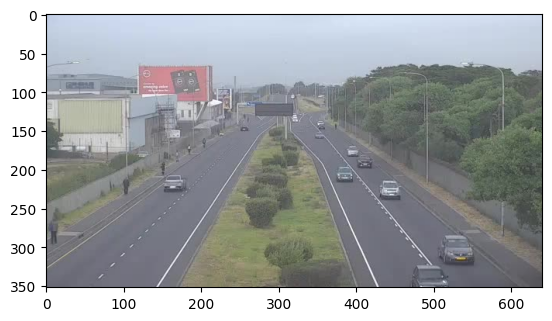

In [36]:
plt.imshow(image1)
plt.show()

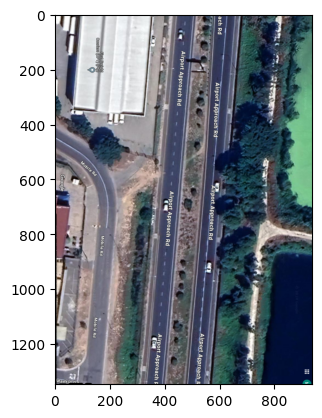

In [35]:
plt.imshow(image2)
plt.show()

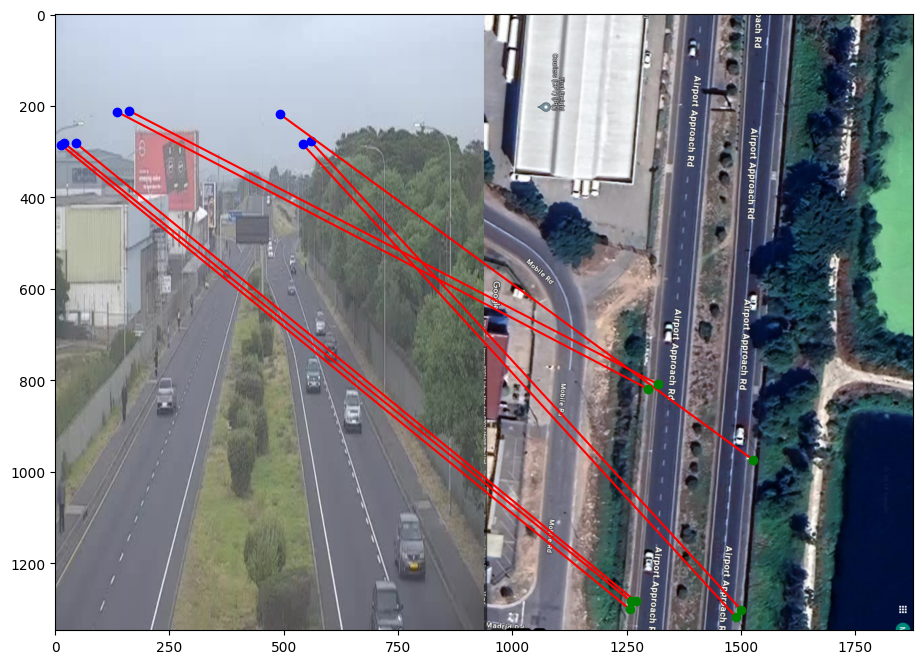

In [28]:
# Dopasuj rozmiar image1 do wysokości image2
height2, width2, _ = image2.shape
image1_resized = np.array(Image.fromarray(image1).resize((width2, height2)))

# Połącz obrazy na osi poziomej (oś 1)
combined_image = np.hstack((image1_resized, image2[:, :, :3]))  # Usuń 4. kanał (jeśli RGBA w image2)

# Wyświetl dopasowania
plot_matches(image1_resized, image2[:, :, :3], points1, points2)

In [38]:
image1.shape, image2.shape

((352, 640, 3), (1347, 938, 4))

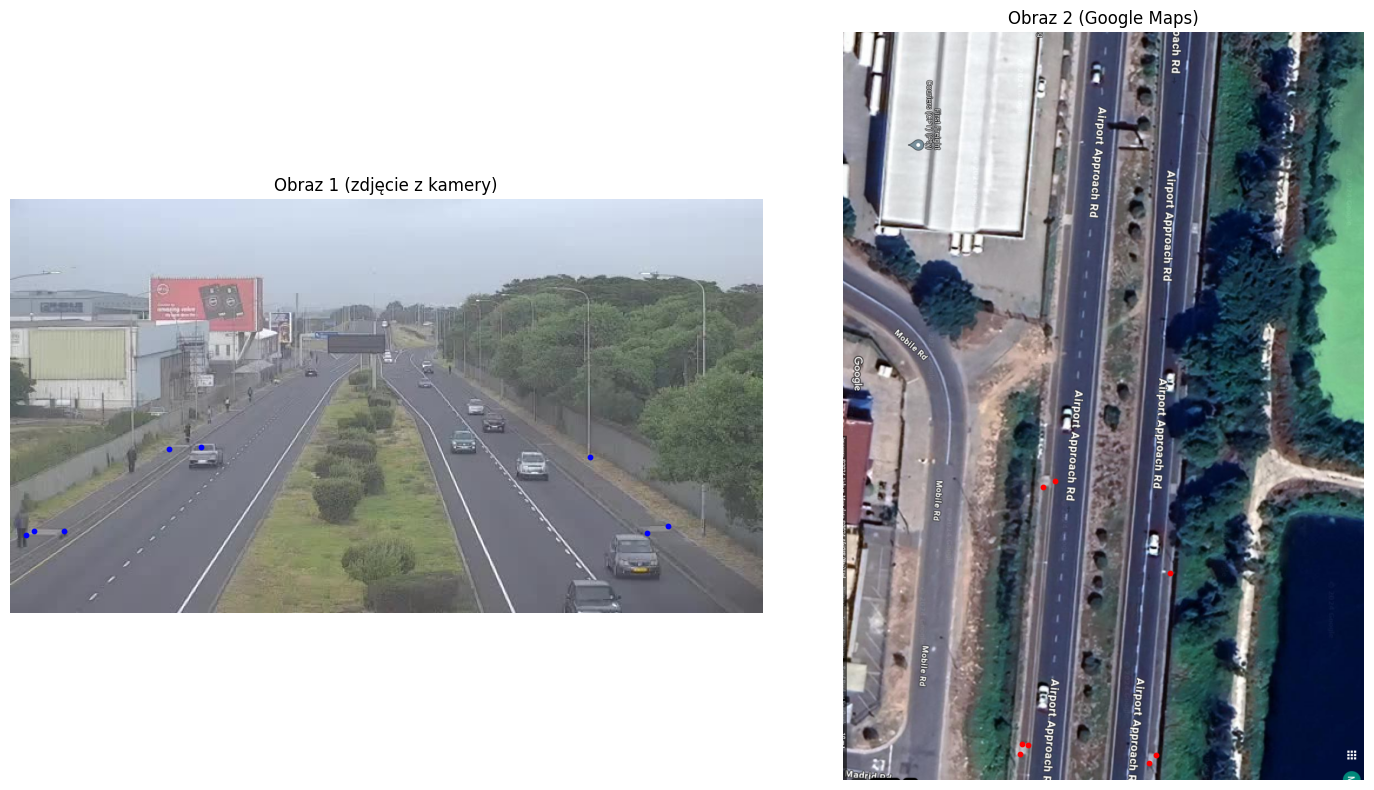

In [43]:
import matplotlib.pyplot as plt

# Wyświetl obrazy obok siebie
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# Pierwszy obraz
ax[0].imshow(image1)
ax[0].scatter(points1[:, 0], points1[:, 1], c='blue', s=10)
ax[0].set_title("Obraz 1 (zdjęcie z kamery)")
ax[0].axis("off")

# Drugi obraz
ax[1].imshow(image2[:, :, :3])  # Usuń kanał alfa, jeśli istnieje
ax[1].scatter(points2[:, 0], points2[:, 1], c='red', s=10)
ax[1].set_title("Obraz 2 (Google Maps)")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [44]:
H = compute_homography(points1, points2)

In [45]:
transformed_image = transform_image(image1, H, image2.shape[:2])

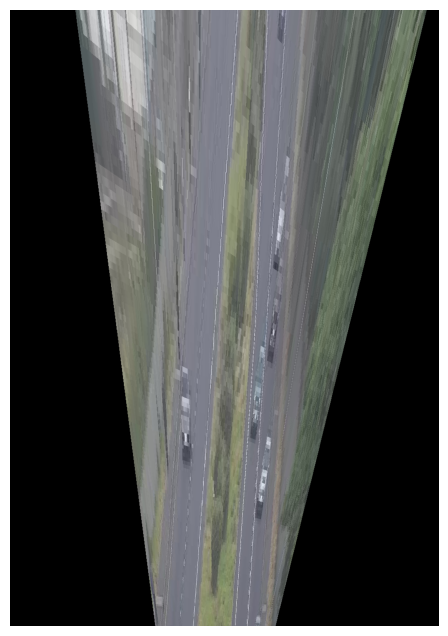

In [46]:
plt.figure(figsize=(10, 8))
plt.imshow(transformed_image)
plt.axis('off')
plt.show()

In [50]:
def transform_yolo_boxes(yolo_file, H):
    data = loadmat(yolo_file)
    boxes = data['xyxy']
    transformed_boxes = []
    for box in boxes:
        corners = [
            [box[0], box[1], 1],  # bottom-left
            [box[2], box[1], 1],  # bottom-right
            [box[0], box[3], 1],  # top-left
            [box[2], box[3], 1],  # top-right
        ]
        transformed_corners = [np.dot(H, corner) for corner in corners]
        transformed_corners = [[c[0] / c[2], c[1] / c[2]] for c in transformed_corners]
        x_min = min(c[0] for c in transformed_corners)
        y_min = min(c[1] for c in transformed_corners)
        x_max = max(c[0] for c in transformed_corners)
        y_max = max(c[1] for c in transformed_corners)
        transformed_boxes.append([x_min, y_min, x_max, y_max])
    return np.array(transformed_boxes)

In [54]:
# Przetwarzanie YOLO plików
yolo_files = sorted([f for f in os.listdir('data/yolo') if f.endswith('.mat')])
for i, yolo_file in enumerate(yolo_files):
    yolo_path = os.path.join('data/yolo', yolo_file)
    transformed_boxes = transform_yolo_boxes(yolo_path, H)
    output_yolo_filename = f"yolo_out/yolooutput_{i+1:05d}.mat"
    savemat(output_yolo_filename, {'bbox': transformed_boxes})
    print(f"Zaktualizowano dane YOLO i zapisano jako {output_yolo_filename}")

Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00001.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00002.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00003.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00004.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00005.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00006.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00007.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00008.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00009.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00010.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00011.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00012.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00013.mat
Zaktualizowano dane YOLO i zapisano jako yolo_out/yolooutput_00014.mat
Zaktua

In [56]:
def transform_and_save_images(input_folder, output_folder, H, output_size):
    # Upewnij się, że folder wyjściowy istnieje
    os.makedirs(output_folder, exist_ok=True)
    
    # Pobierz listę wszystkich plików w folderze wejściowym
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))])
    
    # Przetwarzaj każdy obraz
    for image_file in image_files:
        # Wczytaj obraz
        image_path = os.path.join(input_folder, image_file)
        image = np.array(Image.open(image_path))
        
        # Przekształć obraz
        transformed_image = transform_image(image, H, output_size)
        
        # Zapisz obraz w folderze wyjściowym
        output_path = os.path.join(output_folder, image_file)
        Image.fromarray(transformed_image).save(output_path)
        print(f"Przekształcony obraz zapisano jako {output_path}")

def transform_image(image, H, output_size):
    height, width = output_size
    transformed_image = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        for x in range(width):
            original_coords = np.array([x, y, 1])
            mapped_coords = np.dot(np.linalg.inv(H), original_coords)
            mapped_coords /= mapped_coords[2]
            orig_x, orig_y = int(mapped_coords[0]), int(mapped_coords[1])
            if 0 <= orig_x < image.shape[1] and 0 <= orig_y < image.shape[0]:
                transformed_image[y, x] = image[orig_y, orig_x]
    return transformed_image

# Ścieżki do folderów i ustawienia
input_folder = "data/images/"
output_folder = "mod_images/"
output_size = (1080, 1920)  # Przykładowe rozmiary (dostosuj do swojego projektu)
H = compute_homography(points1, points2)  # Zakładamy, że H jest już obliczone

# Wywołanie funkcji
transform_and_save_images(input_folder, output_folder, H, output_size)

Przekształcony obraz zapisano jako mod_images/img_0001.jpg
Przekształcony obraz zapisano jako mod_images/img_0002.jpg
Przekształcony obraz zapisano jako mod_images/img_0003.jpg
Przekształcony obraz zapisano jako mod_images/img_0004.jpg
Przekształcony obraz zapisano jako mod_images/img_0005.jpg
Przekształcony obraz zapisano jako mod_images/img_0006.jpg
Przekształcony obraz zapisano jako mod_images/img_0007.jpg
Przekształcony obraz zapisano jako mod_images/img_0008.jpg
Przekształcony obraz zapisano jako mod_images/img_0009.jpg
Przekształcony obraz zapisano jako mod_images/img_0010.jpg
Przekształcony obraz zapisano jako mod_images/img_0011.jpg
Przekształcony obraz zapisano jako mod_images/img_0012.jpg
Przekształcony obraz zapisano jako mod_images/img_0013.jpg
Przekształcony obraz zapisano jako mod_images/img_0014.jpg
Przekształcony obraz zapisano jako mod_images/img_0015.jpg
Przekształcony obraz zapisano jako mod_images/img_0016.jpg
Przekształcony obraz zapisano jako mod_images/img_0017.j

KeyboardInterrupt: 

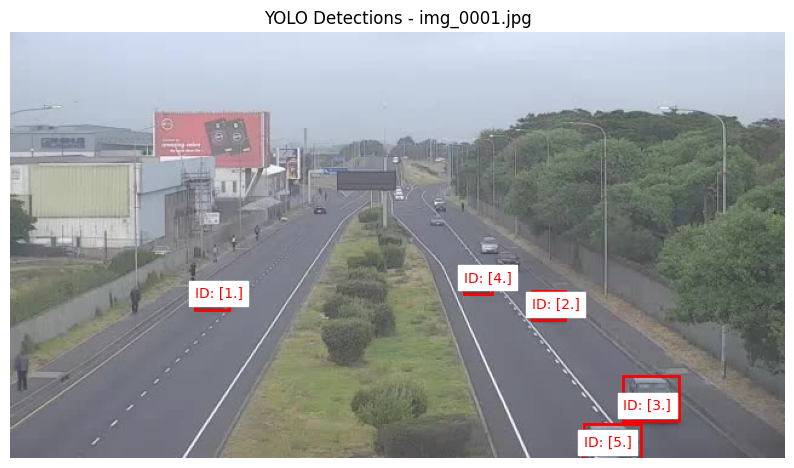

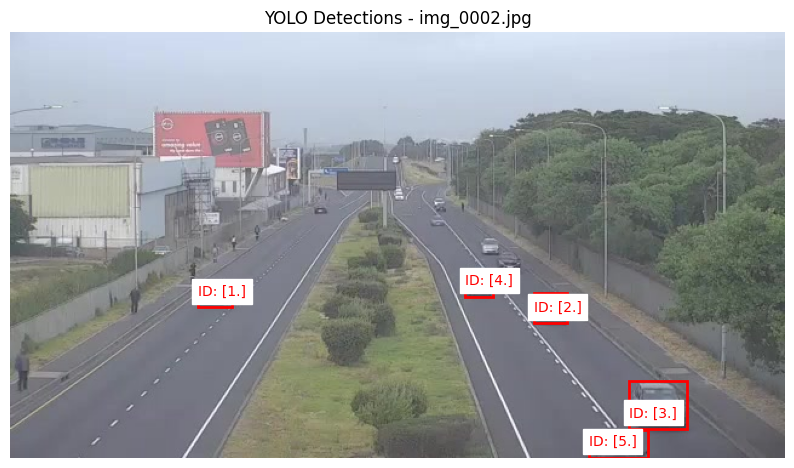

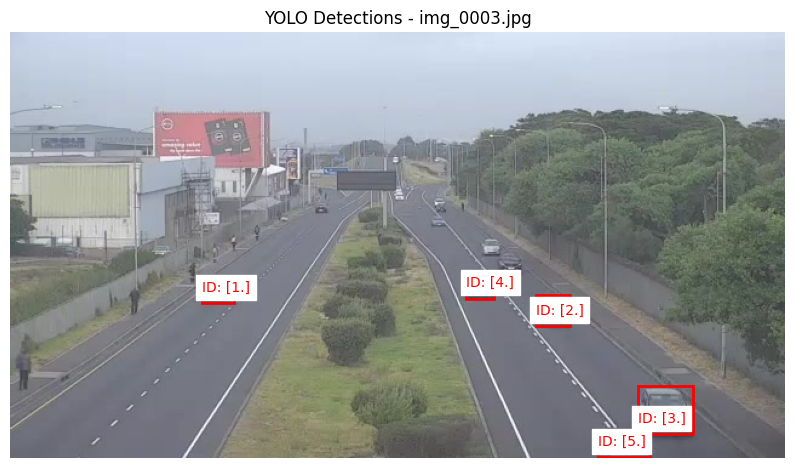

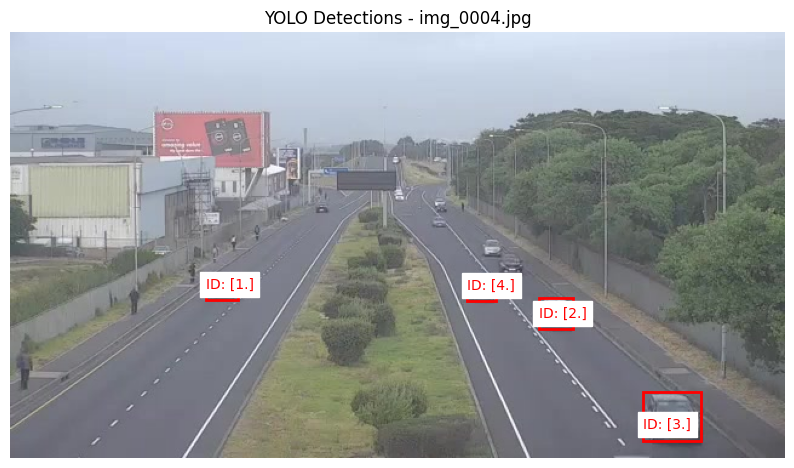

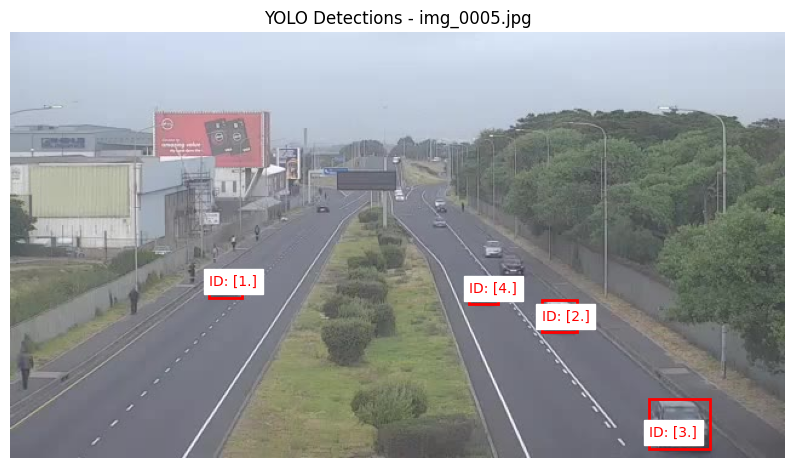

In [57]:
def display_yolo_detections(image_folder, yolo_folder, n=5):
    # Pobierz listę obrazów i plików YOLO
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))])
    yolo_files = sorted([f for f in os.listdir(yolo_folder) if f.endswith('.mat')])
    
    # Iteruj przez pierwsze n plików
    for i in range(min(n, len(image_files))):
        # Wczytaj obraz
        image_path = os.path.join(image_folder, image_files[i])
        image = Image.open(image_path)
        
        # Wczytaj plik YOLO
        yolo_path = os.path.join(yolo_folder, yolo_files[i])
        yolo_data = scipy.io.loadmat(yolo_path)
        
        # Pobierz detekcje: bounding boxy i ich ID
        bboxes = yolo_data['xyxy']  # Macierz [M x 4]: [x_blc, y_blc, x_trc, y_trc]
        ids = yolo_data['id']      # Wektor ID obiektów
        
        # Wyświetl obraz
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.title(f"YOLO Detections - {image_files[i]}")
        
        # Dodaj bounding boxy do obrazu
        for j, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                              edgecolor='red', facecolor='none', linewidth=2))
            plt.text(x1, y1 - 10, f"ID: {ids[j]}", color='red', fontsize=10, backgroundcolor='white')
        
        # Wyświetl wynik
        plt.axis('off')
        plt.show()

# Ścieżki do folderów
image_folder = "data/images/"
yolo_folder = "data/yolo/"

# Wyświetlenie detekcji na 5 pierwszych obrazach
display_yolo_detections(image_folder, yolo_folder, n=5)

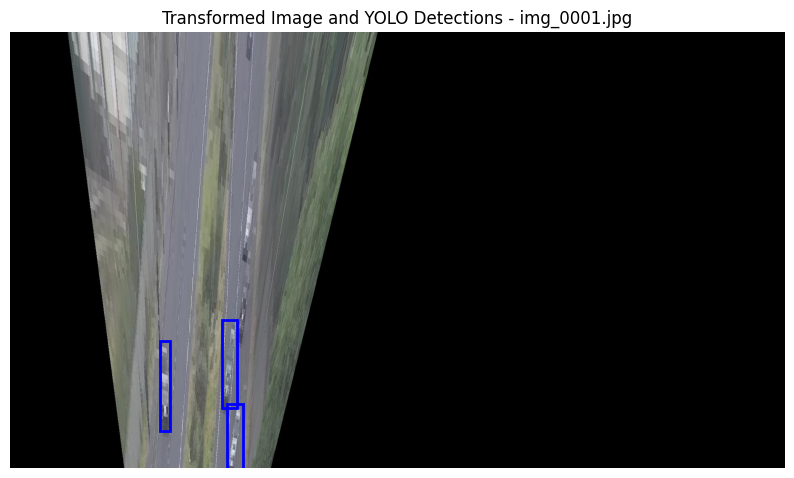

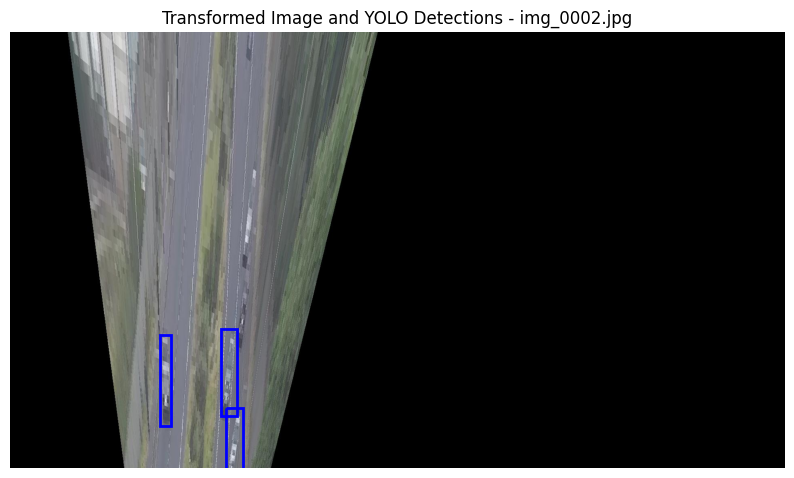

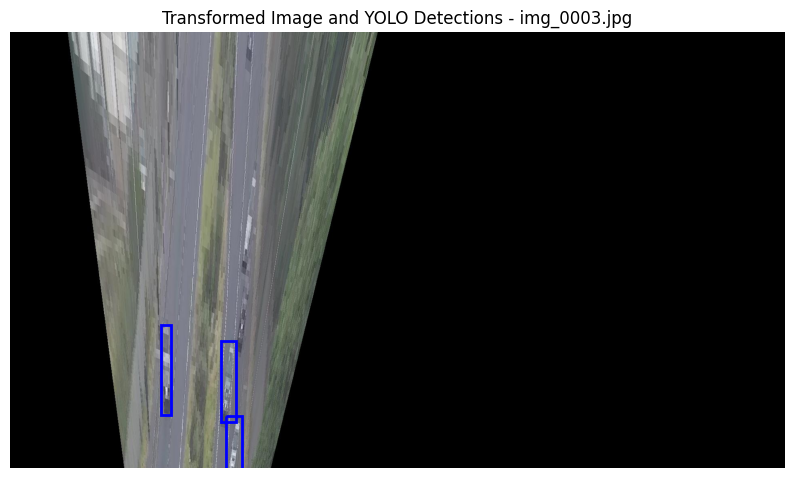

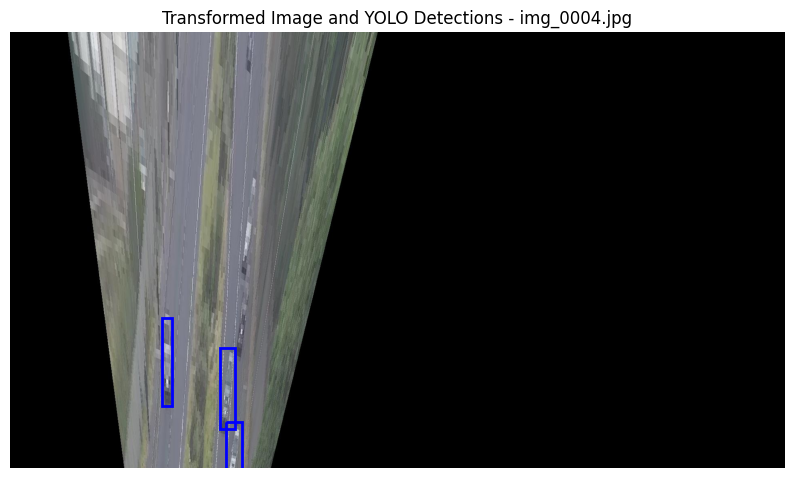

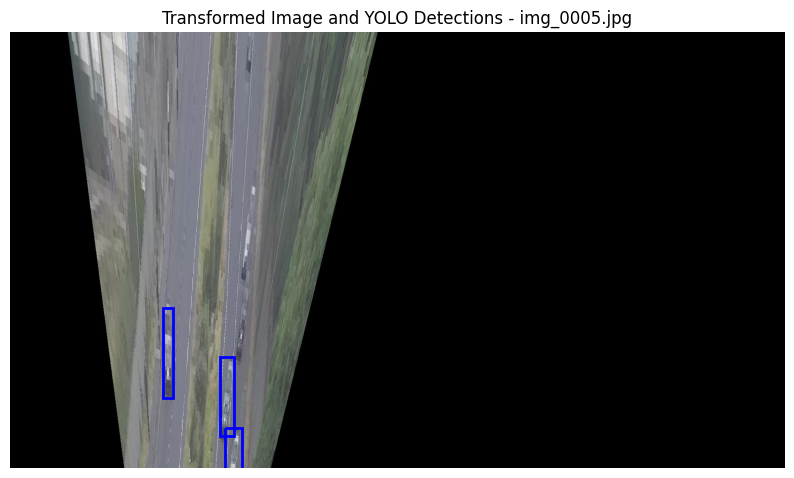

In [58]:
def display_transformed_images_and_detections(mod_images_folder, yolo_out_folder, n=5):
    # Pobierz listę przekształconych obrazów i plików YOLO
    mod_image_files = sorted([f for f in os.listdir(mod_images_folder) if f.endswith(('.jpg', '.png'))])
    yolo_out_files = sorted([f for f in os.listdir(yolo_out_folder) if f.endswith('.mat')])
    
    # Iteruj przez pierwsze n plików
    for i in range(min(n, len(mod_image_files))):
        # Wczytaj przekształcony obraz
        image_path = os.path.join(mod_images_folder, mod_image_files[i])
        image = Image.open(image_path)
        
        # Wczytaj przekształcone dane YOLO
        yolo_path = os.path.join(yolo_out_folder, yolo_out_files[i])
        yolo_data = scipy.io.loadmat(yolo_path)
        
        # Pobierz detekcje: bounding boxy
        bboxes = yolo_data['bbox']  # Macierz [M x 4]: [x_blc, y_blc, x_trc, y_trc]
        
        # Wyświetl obraz
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.title(f"Transformed Image and YOLO Detections - {mod_image_files[i]}")
        
        # Dodaj bounding boxy do obrazu
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                              edgecolor='blue', facecolor='none', linewidth=2))
        
        # Wyświetl wynik
        plt.axis('off')
        plt.show()

# Ścieżki do folderów
mod_images_folder = "mod_images/"
yolo_out_folder = "yolo_out/"

# Wyświetlenie przekształconych obrazów i detekcji YOLO dla pierwszych 5 zdjęć
display_transformed_images_and_detections(mod_images_folder, yolo_out_folder, n=5)